# HALHF v3 Particle Transverse Wake Instability Stages Linac

For simulating the HALHF linac with interstages. The simulation employs the particle transverse wake instability model. Parameter set v3 currently found in the HALHF channel on Mattermost.

Ben Chen, 29 February 2024, University of Oslo

## Import ABEL framework and required classes

In [1]:
import sys
sys.path.append('../')
from abel import *
import numpy as np

from scipy.constants import c, e, m_e, epsilon_0 as eps0
from abel.utilities.relativity import energy2gamma

# Enable the widget backend for interactive plots
%matplotlib widget

# Sets the seed for the pseudo-random number generator in Python to obtain the same sequence of random numbers.
np.random.seed(42) 

## Settings and definitions

In [2]:
# Set the run name
notebook_name = 'HALHFv3_prtcl_instability_stage'

# Determines whether the results of the tracking should be overwritten.
overwrite = True

# Determines whether to use interstages in the tracking. Currently also need to comment out some lines in interstage_basic.py.
use_interstages = True

# Flag for enable interstage drive beam jitter
enable_driver_jitter = False

# Number of stages in the linac.
num_stages = 33

# Determines whether to save plots
save_plots = True

# Determines the DPI value the figures are saved to
save_fig_dpi = 600

# Set the default display DPI
plt.rcParams['figure.dpi'] = 100

# Set default font sizes for figures
import matplotlib.pylab as pylab
params = {
    'axes.titlesize': 14,
    'axes.labelsize': 12.5,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 10
}
pylab.rcParams.update(params)


## Define the input beams

In [3]:
plasma_density = 1.1e+21  # [m^-3]
ramp_beta_mag = 5.0
#ramp_beta_mag = 15.0
enable_radiation_reaction = True
magnetised_beam = False

############# Define drive beam #############
driver = SourceTrapezoid()
driver.current_head = 1e3     # [A]
driver.bunch_length = 550e-6  # [m]
driver.num_particles = 100000
driver.charge = -8.0e-9       # [C]
driver.energy = 7.7e9         # [eV]
driver.rel_energy_spread = 0.01                                        # [m]
driver.z_offset = 1098.0e-6                                          # [m]
driver.emit_nx, driver.emit_ny = 80.0e-6, 80.0e-6                    # [m rad]
driver.beta_x, driver.beta_y = 2.0, 2.0                              # [m]
driver_gamma = energy2gamma(driver.energy)
driver_sigma_x = np.sqrt(driver.emit_nx/driver_gamma*driver.beta_x)  # [m]
driver_sigma_y = np.sqrt(driver.emit_ny/driver_gamma*driver.beta_y)  # [m]

if enable_driver_jitter is True:
    driver.jitter.x = 100e-9  # [m], std
    driver.jitter.y = 100e-9  # [m], std

driver.symmetrize = True
#driver.symmetrize_6d = True  # 
#driver.wallplug_efficiency = 0.19
drive_beam = driver.track()  # Convert a Source object to a Beam object.


############# Define main beam #############
main = SourceBasic()
main.bunch_length = 28.0e-06  # [m], rms. Standard value

main.num_particles = 10000
main.charge = -e * 1.0e10  # [C]

# Energy parameters
main.energy = 5e9  # [eV]
main_gamma = energy2gamma(main.energy)
main.rel_energy_spread = 0.01  # Relative rms energy spread

# Emittances
#emit_max = 90.0e-6  # [m rad], standard value
emit_max = 90.0e-6/2.8  # [m rad]
emit_min = 0.32e-6  # [m rad], standard value
if magnetised_beam is True:
    main.emit_nx = np.sqrt(emit_max*emit_min)  # [m rad], for simulating magnetised beam
    main.angular_momentum = np.sqrt(emit_max/emit_min)*main.emit_nx/2
else:
    main.angular_momentum = 0.0
    main.emit_nx = emit_max  # [m rad]
main.emit_ny = emit_min  # [m rad]

# Beta functions
main.beta_x = beta_matched(plasma_density, main.energy) * ramp_beta_mag  # [m]
main.beta_y = beta_matched(plasma_density, main.energy) * ramp_beta_mag  # [m]
main_sigma_x = np.sqrt(main.emit_nx/main_gamma*main.beta_x)  # [m]
main_sigma_y = np.sqrt(main.emit_ny/main_gamma*main.beta_y)  # [m]

# Offsets
#main.x_offset = main_sigma_x*0.1  # [m]
#main.y_offset = main_sigma_y*0.1  # [m]
#main.x_offset = 100e-9  # [m]
#main.y_offset = 100e-9  # [m]
main.z_offset = 0.00e-6  # [m] # Standard value
#main.z_offset = -2.0e-6  # [m]
#main.x_angle = 1.0e-3  # [rad]
#main.y_angle = 1.0e-3  # [rad]

# Other
main.symmetrize_6d = True
#main.wallplug_efficiency = 0.1

## Define the linac

In [4]:
############# Define the stages #############
stage = StagePrtclTransWakeInstability()
#stage = StageQuasistatic2d()
stage.time_step_mod = 0.03
stage.length = 5.8                          # [m]
stage.nom_energy_gain = 11.56e9             # [eV]
#stage.nom_energy_gain = wave_breaking_field(plasma_density)*0.62*stage.length
stage.plasma_density = plasma_density       # [m^-3]
stage.driver_source = driver
stage.main_source = main
stage.drive_beam = copy.deepcopy(drive_beam)
stage.ramp_beta_mag = ramp_beta_mag
stage.interstages_enabled = use_interstages
stage.enable_radiation_reaction = enable_radiation_reaction


############# Define the first stage #############
first_stage = copy.deepcopy(stage)
first_stage.length = stage.length/2
first_stage.nom_energy_gain = stage.nom_energy_gain/2


############# Define interstages #############
if use_interstages is True:
    #interstage = InterstageBasic()
    interstage = InterstageElegant()
    #interstage.save_evolution = True
    interstage.save_apl_field_map = True
    #interstage.enable_isr = False
    #interstage.enable_csr = False
    interstage.beta0 = lambda energy: stage.matched_beta_function(energy)
    interstage.dipole_length = lambda energy: 1 * np.sqrt(energy/10e9)  # [m(eV)], energy-dependent length
    #interstage.dipole_field = lambda energy: np.min([0.6, 50e9/energy])  # [T]
    interstage.dipole_field = lambda energy: np.min([0.6, 0.6*120e9/energy])  # [T]
    #interstage.dipole_field = lambda energy: np.min([0.7, 0.7*50e9/energy])  # [T]
else:
    interstage = InterstageNull()
first_stage.interstage_dipole_field = interstage.dipole_field
stage.interstage_dipole_field = interstage.dipole_field
#interstage.lens_x_offset = -0.4e-6
#interstage.lens_x_offset = 0.5e-6


############# Define linac #############
linac = Linac(source=main, first_stage=first_stage, stage=stage, interstage=interstage, num_stages=num_stages)

# Transverse wakefield disabled
#linac.set_stage_nom_energy_gain(stage_num=0, nom_energy_gain=5.779957590679402e9)
#linac.set_stage_nom_energy_gain(stage_num=1, nom_energy_gain=11.559738908690523e9)
#linac.set_stage_nom_energy_gain(stage_num=2, nom_energy_gain=11.559421776325696e9)
#linac.set_stage_nom_energy_gain(stage_num=3, nom_energy_gain=11.559011561043071e9)
#linac.set_stage_nom_energy_gain(stage_num=4, nom_energy_gain=11.558545540948444e9)
#linac.set_stage_nom_energy_gain(stage_num=5, nom_energy_gain=11.557999930132645e9)
#linac.set_stage_nom_energy_gain(stage_num=6, nom_energy_gain=11.557404481772124e9)
#linac.set_stage_nom_energy_gain(stage_num=7, nom_energy_gain=11.556819556400058e9)
#linac.set_stage_nom_energy_gain(stage_num=8, nom_energy_gain=11.556125623920181e9)
#linac.set_stage_nom_energy_gain(stage_num=9, nom_energy_gain=11.5552969239925e9)
#linac.set_stage_nom_energy_gain(stage_num=10, nom_energy_gain=11.55438964577462e9)
#linac.set_stage_nom_energy_gain(stage_num=11, nom_energy_gain=11.553290722880504e9)
#linac.set_stage_nom_energy_gain(stage_num=12, nom_energy_gain=11.552289103410857e9)
#linac.set_stage_nom_energy_gain(stage_num=13, nom_energy_gain=11.551706792913109e9)
#linac.set_stage_nom_energy_gain(stage_num=14, nom_energy_gain=11.550927660713171e9)
#linac.set_stage_nom_energy_gain(stage_num=15, nom_energy_gain=11.549932224913022e9)
#linac.set_stage_nom_energy_gain(stage_num=16, nom_energy_gain=11.54879967047728e9)
#linac.set_stage_nom_energy_gain(stage_num=17, nom_energy_gain=e9)
#linac.set_stage_nom_energy_gain(stage_num=18, nom_energy_gain=e9)
#linac.set_stage_nom_energy_gain(stage_num=19, nom_energy_gain=e9)
#linac.set_stage_nom_energy_gain(stage_num=20, nom_energy_gain=e9)
#linac.set_stage_nom_energy_gain(stage_num=21, nom_energy_gain=e9)
#linac.set_stage_nom_energy_gain(stage_num=22, nom_energy_gain=e9)
#linac.set_stage_nom_energy_gain(stage_num=23, nom_energy_gain=e9)
#linac.set_stage_nom_energy_gain(stage_num=24, nom_energy_gain=e9)
#linac.set_stage_nom_energy_gain(stage_num=25, nom_energy_gain=e9)
#linac.set_stage_nom_energy_gain(stage_num=26, nom_energy_gain=e9)
#linac.set_stage_nom_energy_gain(stage_num=27, nom_energy_gain=e9)
#linac.set_stage_nom_energy_gain(stage_num=28, nom_energy_gain=e9)
#linac.set_stage_nom_energy_gain(stage_num=29, nom_energy_gain=e9)
#linac.set_stage_nom_energy_gain(stage_num=30, nom_energy_gain=e9)
#linac.set_stage_nom_energy_gain(stage_num=31, nom_energy_gain=e9)

# Transverse wakefield enabled
#linac.set_stage_nom_energy_gain(stage_num=0, nom_energy_gain=5.861529881573917e9)
#linac.set_stage_nom_energy_gain(stage_num=1, nom_energy_gain=11.62937040041245e9)
#linac.set_stage_nom_energy_gain(stage_num=2, nom_energy_gain=11.482858528312757e9)
#linac.set_stage_nom_energy_gain(stage_num=3, nom_energy_gain=11.614014180956339e9)
#linac.set_stage_nom_energy_gain(stage_num=4, nom_energy_gain=11.639396733432825e9)
#linac.set_stage_nom_energy_gain(stage_num=5, nom_energy_gain=11.656334449097848e9)
#linac.set_stage_nom_energy_gain(stage_num=6, nom_energy_gain=11.599194957944945e9)
#linac.set_stage_nom_energy_gain(stage_num=7, nom_energy_gain=11.649801506527908e9)
#linac.set_stage_nom_energy_gain(stage_num=8, nom_energy_gain=11.632541714623713e9)
#linac.set_stage_nom_energy_gain(stage_num=9, nom_energy_gain=11.59755384712642e9)
#linac.set_stage_nom_energy_gain(stage_num=10, nom_energy_gain=11.613059144027787e9)
#
#linac.set_stage_nom_energy_gain(stage_num=11, nom_energy_gain=11.648252700888136e9)
#linac.set_stage_nom_energy_gain(stage_num=12, nom_energy_gain=11.585998681289027e9)
#linac.set_stage_nom_energy_gain(stage_num=13, nom_energy_gain=11.63930874927621e9)
#linac.set_stage_nom_energy_gain(stage_num=14, nom_energy_gain=11.594205752332385e9)
#linac.set_stage_nom_energy_gain(stage_num=15, nom_energy_gain=11.66694687405402e9)
#linac.set_stage_nom_energy_gain(stage_num=16, nom_energy_gain=11.718402590583082e9)
#linac.set_stage_nom_energy_gain(stage_num=17, nom_energy_gain=11.577600554093891e9)
#linac.set_stage_nom_energy_gain(stage_num=18, nom_energy_gain=11.645168895741932e9)
#linac.set_stage_nom_energy_gain(stage_num=19, nom_energy_gain=11.679092335583107e9)
#linac.set_stage_nom_energy_gain(stage_num=20, nom_energy_gain=11.54442352913938e9)
#linac.set_stage_nom_energy_gain(stage_num=21, nom_energy_gain=11.631972601263527e9)
#linac.set_stage_nom_energy_gain(stage_num=22, nom_energy_gain=11.719592009830649e9)
#linac.set_stage_nom_energy_gain(stage_num=23, nom_energy_gain=11.625254020942691e9)
#linac.set_stage_nom_energy_gain(stage_num=24, nom_energy_gain=11.702676169907534e9)
#linac.set_stage_nom_energy_gain(stage_num=25, nom_energy_gain=11.621848323875724e9)
#linac.set_stage_nom_energy_gain(stage_num=26, nom_energy_gain=11.579323663396565e9)
#linac.set_stage_nom_energy_gain(stage_num=27, nom_energy_gain=11.572763234697334e9)
#linac.set_stage_nom_energy_gain(stage_num=28, nom_energy_gain=11.61457092543958e9)
#linac.set_stage_nom_energy_gain(stage_num=29, nom_energy_gain=11.619543862242892e9)
#linac.set_stage_nom_energy_gain(stage_num=30, nom_energy_gain=11.630873078039997e9)
#linac.set_stage_nom_energy_gain(stage_num=31, nom_energy_gain=11.572415477917843e9)


#linac.set_interstage_lens_offset(interstage_num=0, lens_x_offset=-2.3e-6)
#linac.set_interstage_lens_offset(interstage_num=1, lens_x_offset=-1.3e-6)
#linac.set_interstage_lens_offset(interstage_num=2, lens_x_offset=-1.1e-6)
#linac.set_interstage_lens_offset(interstage_num=3, lens_x_offset=-1.5e-6)
#linac.set_interstage_lens_offset(interstage_num=4, lens_x_offset=-0.8e-6)
#linac.set_interstage_lens_offset(interstage_num=5, lens_x_offset=-0.7e-6)
#linac.set_interstage_lens_offset(interstage_num=6, lens_x_offset=-0.7e-6)
#linac.set_interstage_lens_offset(interstage_num=7, lens_x_offset=-1.1e-6)
#linac.set_interstage_lens_offset(interstage_num=8, lens_x_offset=-0.9e-6)
#linac.set_interstage_lens_offset(interstage_num=9, lens_x_offset=0.0e-6)
#linac.set_interstage_lens_offset(interstage_num=10, lens_x_offset=1.1e-6)

In [5]:
#shot_num = 0
#stage_num = 10
#beam_before = linac[shot_num].get_beam(stage_num*2)
#beam_after = linac[shot_num].get_beam(stage_num*2+1)
#
#print(beam_after.energy()/1e9 - beam_before.energy()/1e9)
#print((beam_after.energy()/1e9-linac.nom_stage_energies()[stage_num*2+1]/1e9)/(linac.nom_stage_energies()[stage_num*2+1]/1e9))
#print(((beam_after.energy()/1e9 - beam_before.energy()/1e9)-(first_stage.nom_energy_gain/1e9))/(first_stage.nom_energy_gain/1e9), '\n')
#
#print(linac[shot_num].get_beam(stage_num*2+2).x_offset())
#print(linac[shot_num].get_beam(stage_num*2+2).x_angle())
#print(linac[shot_num].get_beam(stage_num*2+2).norm_amplitude_x(plasma_density, clean=False), '\n')





#
#print(linac[shot_num].get_beam((stage_num+1)*2+1).x_offset())
#print(linac[shot_num].get_beam((stage_num+1)*2+1).x_angle())
#print(linac[shot_num].get_beam((stage_num+1)*2+1).norm_amplitude_x(plasma_density, clean=False))

#print(linac[shot_num].get_beam(stage_num*2+2).norm_amplitude_x(plasma_density, clean=False)/linac[shot_num].get_beam(0).norm_amplitude_x(plasma_density, clean=False))
#print(linac[shot_num].get_beam(1).x_offset())
#print(linac[shot_num].get_beam(1).x_angle())

#print(wave_breaking_field(plasma_density)*0.62)
##
##
#beam_after.energy()/1e9
#linac[shot_num].get_beam(5).energy()/1e9

#linac.stages[stage_num].nom_energy_gain/1e9
#linac.stages[0].nom_energy_gain/1e9

#linac.nom_stage_energies()

#first_stage.nom_energy_gain
#stage.nom_energy_gain

1.1
1.727412032577503e-07
2.0629555256548292e-06
0.0004302311306859549

0.7
1.9419016128805631e-07
1.605398621608176e-06
0.0003940808520013708 

0.3
2.976192561595848e-07
1.298242935337752e-06
0.0004921085821900748

-0.1
4.0397533338493794e-07
7.230749090207286e-07
0.0006113054352627018

-0.5
4.6373113691133066e-07
4.065834554081567e-07
0.0006911785805154327

-0.9
5.377862608621837e-07
-1.6365591926429934e-07
0.0007981244783616285 

0.0007981244783616285

## Calculate input longitudinal field, plasma bubble radius and longitudinal number profile with Wake-T

In [6]:
main_beam = main.track()     # Convert a Source object to a Beam object.

# Define a Wake-T stage
stage_wakeT = StageWakeT()
stage_wakeT.driver_source = driver
k_beta = k_p(stage.plasma_density)/np.sqrt(2*min(main_beam.gamma(),drive_beam.gamma()/2))
lambda_betatron = (2*np.pi/k_beta)
stage_wakeT.length = lambda_betatron/10  # [m]
stage_wakeT.plasma_density = stage.plasma_density  # [m^-3]
stage_wakeT.ramp_beta_mag = first_stage.ramp_beta_mag
#stage_wakeT.keep_data = True


# Run the Wake-T stage
beam_copy = copy.deepcopy(main_beam)
beam_wakeT = stage_wakeT.track(beam_copy)

Plasma stage: 100%|█████████████████████████████████████████████| 0.012358/0.012358 m [00:00]


/Users/ben_c/Library/CloudStorage/OneDrive-UniversitetetiOslo/Software/opal_env/lib/python3.10/site-packages/aptools/data_analysis/beam_diagnostics.py:524: RuntimeWarning: invalid value encountered in sqrt
  em_x = np.sqrt(np.linalg.det(cov_x.astype(np.float32, copy=False)))


### Extract data

In [7]:
# Extract initial beam densities
beams_dens = stage_wakeT.initial.beam.density.rho
beams_extent = stage_wakeT.initial.beam.density.extent

# Extract transverse fields
Ex = stage_wakeT.initial.plasma.wakefield.Exs
By = stage_wakeT.initial.plasma.wakefield.Bys
info_Ex = stage_wakeT.initial.plasma.wakefield.Exs_metadata
Ex_cBy = Ex - c*By
zs_Ex = info_Ex.z
rs_Ex = info_Ex.r

# Extract longitudinal E-field
Ez_wakeT = stage_wakeT.initial.plasma.wakefield.Ezs
info_Ez = stage_wakeT.initial.plasma.wakefield.Ezs_metadata
zs_Ez_wakeT = info_Ez.z
rs_Ez = info_Ez.r

# Extract axial longitudinal E-field
Ez_axis_wakeT = stage_wakeT.initial.plasma.wakefield.onaxis.Ezs
zs_Ez_wakeT = stage_wakeT.initial.plasma.wakefield.onaxis.zs

# Extract plasma charge density
rho = stage_wakeT.initial.plasma.density.rho
info_rho = stage_wakeT.initial.plasma.density.metadata

# Calculate the number density
plasma_num_density = rho/stage_wakeT.plasma_density
# Extract coordinates
zs_rho = info_rho.z
rs_rho = info_rho.r

# Extract the plasma bubble radius
bubble_radius_wakeT = first_stage.get_bubble_radius(plasma_num_density, rs_rho, main_offset=main_beam.x_offset(), threshold=0.8)

# Extract number density profiles for drive and main beam
zs_dNdz = stage_wakeT.initial.beam.current.zs
dNdz = stage_wakeT.initial.beam.current.Is/-e/c

### Make plots

Text(0, 0.5, '$\\partial N/\\partial z$ [$\\mathrm{m}^{-1}$]')

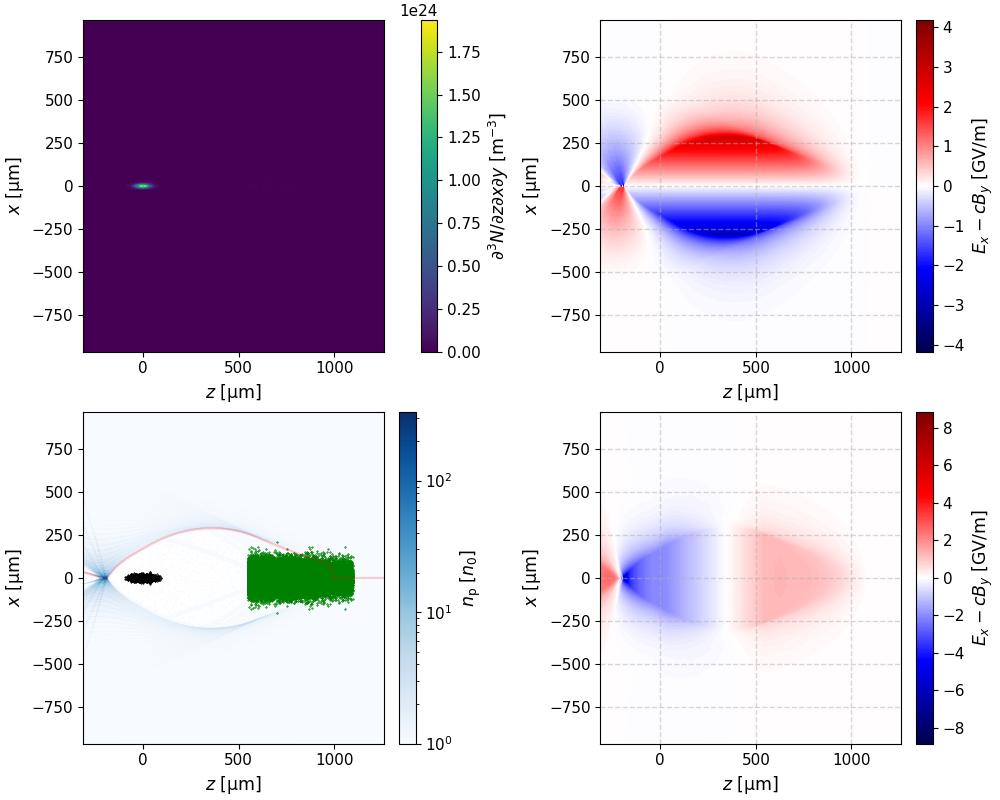

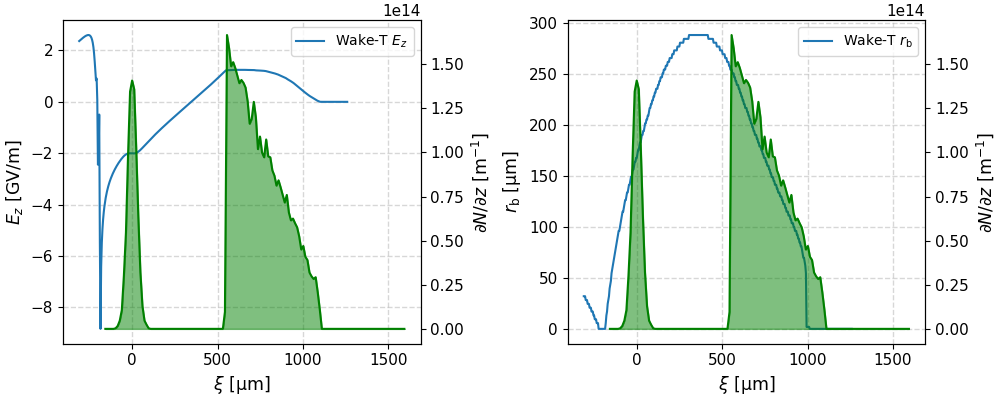

In [8]:
main_beam_ramped = copy.deepcopy(main_beam)
main_beam_ramped.magnify_beta_function(1/ramp_beta_mag, axis_defining_beam=drive_beam)  # Demagnified beam

# Labels for plots
zlab = '$z$ [$\mathrm{\mu}$m]'
xilab = r'$\xi$ [$\mathrm{\mu}$m]'
xlab = '$x$ [$\mathrm{\mu}$m]'
field_lab = '$E_z$ [GV/m]'
dN_dz_lab = '$\partial N/\partial z$ [$\mathrm{m}^{-1}$]'

# Set up a figure with axes
fig_wakeT, axs_wakeT = plt.subplots(nrows=2, ncols=2, layout="constrained", figsize=(10, 4*2))

# Plot the bunches
first_stage.imshow_plot(beams_dens, axes=axs_wakeT[0][0], extent=beams_extent*1e6, colmap='viridis', xlab=zlab, ylab=xlab, clab='$\partial^3 N/\partial z\partial x\partial y$ [$\mathrm{m}^{-3}$]', gridOn=False, origin='lower', log_cax=False)

# Plot the transverse fields
Ex_extent = stage_wakeT.initial.plasma.wakefield.Exs_metadata.imshow_extent*1e6
first_stage.imshow_plot(Ex_cBy/1e9, axes=axs_wakeT[0][1], extent=Ex_extent, vmin=Ex_cBy.min()/1e9, vmax=-Ex_cBy.min()/1e9, colmap='seismic', xlab=zlab, ylab=xlab, clab='$E_x-cB_y$ [GV/m]', gridOn=True, origin='lower')

# Plot the plasma number density
rho_extent = stage_wakeT.initial.plasma.density.extent*1e6
first_stage.imshow_plot(plasma_num_density, axes=axs_wakeT[1][0], extent=rho_extent, colmap='Blues', xlab=zlab, ylab=xlab, clab='$n_\mathrm{p}$ [$n_0$]', gridOn=False, origin='lower', log_cax=True)
axs_wakeT[1][0].plot(zs_rho*1e6, (bubble_radius_wakeT+main.x_offset)*1e6, 'r', alpha=0.2)
axs_wakeT[1][0].scatter(main_beam_ramped.zs()*1e6, main_beam_ramped.xs()*1e6, s=0.1, color='k')
drive_beam_ramped = copy.deepcopy(drive_beam)
drive_beam_ramped.magnify_beta_function(1/ramp_beta_mag, axis_defining_beam=drive_beam)  # Demagnified beam
axs_wakeT[1][0].scatter(drive_beam_ramped.zs()*1e6, drive_beam_ramped.xs()*1e6, s=0.1, color='g')

# Plot the longitudinal electric field
Ez_extent = stage_wakeT.initial.plasma.wakefield.Ezs_metadata.imshow_extent*1e6
first_stage.imshow_plot(Ez_wakeT/1e9, axes=axs_wakeT[1][1], extent=Ez_extent, vmin=Ez_wakeT.min()/1e9, vmax=-Ez_wakeT.min()/1e9, colmap='seismic', xlab=zlab, ylab=xlab, clab='$E_x-cB_y$ [GV/m]', gridOn=True, origin='lower')

# Set up a figure with axes
fig_wakeT2, axs_wakeT2 = plt.subplots(nrows=1, ncols=2, layout="compressed", figsize=(10, 4))

# Plot longitudinal axial E-field
axs_wakeT2[0].plot(zs_Ez_wakeT*1e6, Ez_axis_wakeT/1e9, label='Wake-T $E_z$')
axs_wakeT2[0].legend()
axs_wakeT2[0].grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=.5)
axs_wakeT2[0].set_xlabel(xilab)
axs_wakeT2[0].set_ylabel(field_lab)
ax = axs_wakeT2[0].twinx()
ax.fill_between(x=zs_dNdz*1e6, y1=dNdz , y2=0, color='g', alpha=0.5)
ax.plot(zs_dNdz*1e6, dNdz, 'g')
ax.set_ylabel(dN_dz_lab)

# Plot the plasma bubble radius
axs_wakeT2[1].plot((zs_rho)*1e6, bubble_radius_wakeT*1e6, label='Wake-T $r_\mathrm{b}$')
axs_wakeT2[1].legend()
axs_wakeT2[1].grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=.5)
axs_wakeT2[1].set_xlabel(xilab)
axs_wakeT2[1].set_ylabel('$r_\mathrm{b}$ [$\mathrm{\mu}$m]')
ax = axs_wakeT2[1].twinx()
ax.fill_between(x=zs_dNdz*1e6, y1=dNdz , y2=0, color='g', alpha=0.5)
ax.plot(zs_dNdz*1e6, dNdz, 'g')
ax.set_ylabel(dN_dz_lab)

#stage_wakeT.plot_evolution()
#beam_wakeT.plot_lps()

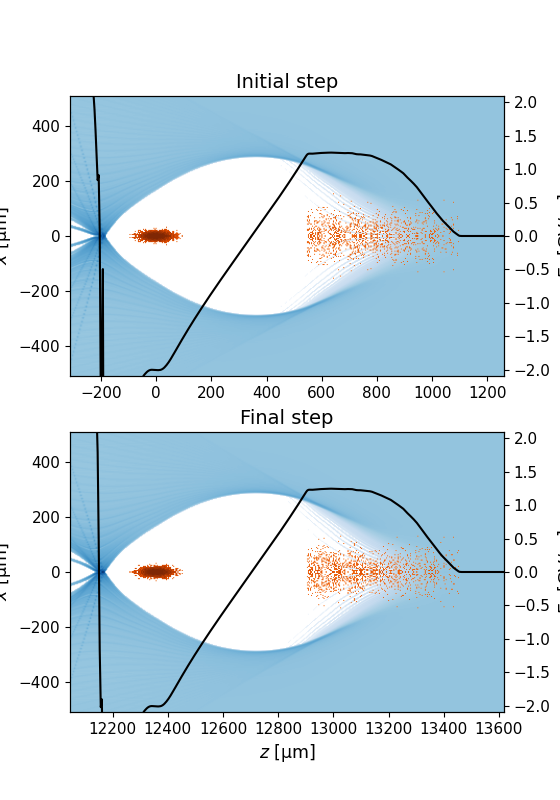

In [9]:
stage_wakeT.plot_wake()

## Summary of initial beam

In [10]:
_, init_Ez_fit_obj = first_stage.Ez_shift_fit(Ez_axis_wakeT, zs_Ez_wakeT, main_beam_ramped)
first_stage.Ez_fit_obj = init_Ez_fit_obj

_, init_rb_fit_obj = first_stage.rb_shift_fit(bubble_radius_wakeT, zs_rho, main_beam_ramped)
first_stage.rb_fit_obj = init_rb_fit_obj

first_stage.print_initial_summary(drive_beam, main_beam)

Time step [betatron wavelength/c]:			 0.030
Interstages enabled:					 True
Interstage dipole field:				 0.600
Ramp beta magnification:				 5.000
Radiation reaction enabled:				 True
Symmetrised main beam:					 False
Symmetrised drive beam:					 True

Stage length [m]:					 2.900
Plasma density [m^-3]:					 1.100e+21
Drive beam x jitter (std) [um]:				 0.000
Drive beam y jitter (std) [um]:				 0.000
----------------------------------------------------------------------

-------------------------------------------------------------------------------------
Quantity 					 Drive beam 		 Main beam
-------------------------------------------------------------------------------------
Number of macroparticles:			 100000			 10000
Initial beam population:			 4.993e+10 		 1.000e+10

Weighted main beam gradient [GV/m]:			  		 -1.999
Initial mean gamma:				 15068.514 		 9784.756
Initial mean energy [GeV]:			 7.700 		 5.000
Initial rms energy spread [%]:			 0.998 			 1.031

Initial beam x offset [um]

In [11]:
#first_stage.scatter_diags(beam=main_beam, n_th_particle=1)
#first_stage.density_map_diags(beam=main_beam)

## Perform tracking

In [ ]:
import time

# Start time
start_time = time.time()
cpu_start_time = time.process_time()

# Tracking
linac.run(notebook_name, overwrite=overwrite)

# End time
end_time = time.time()
cpu_end_time = time.process_time()

# Time usage
print('Time taken:', end_time - start_time, 'seconds')
print('CPU seconds:', cpu_end_time - cpu_start_time)

Tracking element 1 (SourceBasic, stage 0, s = 0.0 m, 5.0 GeV, -1.60 nC, 1.0% rms, 32.2/0.3 µm-rad)
Plasma stage: 100%|█████████████████████████████████████████████| 0.012358/0.012358 m [00:00]


Instability tracking 100.0%: 100%|██████████▉| 99.99999999999919/100 [00:12<00:00,  7.78it/s]


Tracking element 2 (StagePrtclTransWakeInstability, stage 1, s = 2.9 m, 10.9 GeV, -1.60 nC, 2.2% rms, 32.2/0.3 µm-rad)
Tracking element 3 (InterstageElegant, stage 1, s = 8.5 m, 10.9 GeV, -1.60 nC, 2.2% rms, 32.4/0.3 µm-rad)
Plasma stage: 100%|█████████████████████████████████████████████| 0.012358/0.012358 m [00:00]


/Users/ben_c/Library/CloudStorage/OneDrive-UniversitetetiOslo/Software/opal_env/lib/python3.10/site-packages/aptools/data_analysis/beam_diagnostics.py:524: RuntimeWarning: invalid value encountered in sqrt
  em_x = np.sqrt(np.linalg.det(cov_x.astype(np.float32, copy=False)))
Instability tracking 100.0%: 100%|██████████| 100.00000000000178/100 [00:13<00:00,  7.18it/s]


Tracking element 4 (StagePrtclTransWakeInstability, stage 2, s = 14.3 m, 22.5 GeV, -1.60 nC, 2.7% rms, 32.5/0.3 µm-rad)
Tracking element 5 (InterstageElegant, stage 2, s = 22.4 m, 22.5 GeV, -1.60 nC, 2.7% rms, 32.8/0.3 µm-rad)
Plasma stage: 100%|█████████████████████████████████████████████| 0.012358/0.012358 m [00:00]


Instability tracking 100.0%: 100%|██████████▉| 99.99999999999791/100 [00:09<00:00, 10.72it/s]


Tracking element 6 (StagePrtclTransWakeInstability, stage 3, s = 28.2 m, 34.2 GeV, -1.60 nC, 2.7% rms, 32.8/0.3 µm-rad)
Tracking element 7 (InterstageElegant, stage 3, s = 38.2 m, 34.2 GeV, -1.60 nC, 2.7% rms, 32.9/0.3 µm-rad)
Plasma stage: 100%|█████████████████████████████████████████████| 0.012358/0.012358 m [00:00]


Instability tracking 100.0%: 100%|██████████| 100.00000000000189/100 [00:07<00:00, 12.90it/s]


Tracking element 8 (StagePrtclTransWakeInstability, stage 4, s = 44.0 m, 45.8 GeV, -1.60 nC, 2.6% rms, 33.0/0.3 µm-rad)
Tracking element 9 (InterstageElegant, stage 4, s = 55.6 m, 45.8 GeV, -1.60 nC, 2.6% rms, 33.3/0.3 µm-rad)
Plasma stage: 100%|█████████████████████████████████████████████| 0.012358/0.012358 m [00:00]


Instability tracking 100.0%: 100%|██████████| 100.00000000000102/100 [00:06<00:00, 15.28it/s]


Tracking element 10 (StagePrtclTransWakeInstability, stage 5, s = 61.4 m, 57.4 GeV, -1.60 nC, 2.5% rms, 33.4/0.3 µm-rad)
Tracking element 11 (InterstageElegant, stage 5, s = 74.3 m, 57.4 GeV, -1.60 nC, 2.5% rms, 33.9/0.3 µm-rad)
Plasma stage: 100%|█████████████████████████████████████████████| 0.012358/0.012358 m [00:00]


Instability tracking 100.0%: 100%|██████████▉| 99.99999999999967/100 [00:06<00:00, 16.38it/s]


Tracking element 12 (StagePrtclTransWakeInstability, stage 6, s = 80.1 m, 68.8 GeV, -1.60 nC, 2.3% rms, 33.9/0.3 µm-rad)
Tracking element 13 (InterstageElegant, stage 6, s = 94.3 m, 68.8 GeV, -1.60 nC, 2.3% rms, 34.2/0.3 µm-rad)
Plasma stage: 100%|█████████████████████████████████████████████| 0.012358/0.012358 m [00:00]


Instability tracking 100.0%: 100%|██████████▉| 99.99999999999851/100 [00:05<00:00, 18.31it/s]


Tracking element 14 (StagePrtclTransWakeInstability, stage 7, s = 100.1 m, 80.3 GeV, -1.60 nC, 2.2% rms, 34.2/0.3 µm-rad)
Tracking element 15 (InterstageElegant, stage 7, s = 115.5 m, 80.3 GeV, -1.60 nC, 2.2% rms, 35.4/0.3 µm-rad)
Plasma stage: 100%|█████████████████████████████████████████████| 0.012358/0.012358 m [00:00]


Instability tracking 100.0%: 100%|██████████▉| 99.99999999999982/100 [00:05<00:00, 19.48it/s]


Tracking element 16 (StagePrtclTransWakeInstability, stage 8, s = 121.3 m, 91.9 GeV, -1.60 nC, 2.1% rms, 35.4/0.3 µm-rad)


In [ ]:
#linac.scan('R56_scan', lambda obj, val: setattr(obj.stage, 'ramp', val) or obj, scan_values, num_shots_per_step = 1, overwrite=True, parallel = True); 
scan_values = np.linspace(1, 15, 8)

In [ ]:
shot_num = 0
stage_num = 32
stage_tracked = linac[shot_num].stages[stage_num]  # Get a specific acceleration stage in a linac. Zero indexing.
beam_out = linac[shot_num].get_beam(stage_num*2+1)  # Get the corresponding beam after the acceleration stage. Zero indexing.

stage_tracked.print_current_summary(stage_tracked.drive_beam, linac.initial_beam, beam_out)

## Diagnostic of extracted beam

In [ ]:
# Make plots folder
plot_path = linac.run_path() + 'plots' + os.sep
if not os.path.exists(plot_path):
    os.mkdir(plot_path)

### Cut-out bubble radius, longitudinal E-field and longitudinal beam profile

In [ ]:
stage_tracked.plot_Ez_rb_cut()

# Save the figure
if save_plots is True and overwrite is True:
    filename = plot_path + 'Ez_rb_' + 'shot' + str(shot_num) + '_prtclInstabilityStage' + str(stage_num)
    plt.savefig(filename+'.pdf', format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)
    plt.savefig(filename+'.png', format='png', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

In [ ]:
stage_tracked.plot_wake()

# Save the figure
if save_plots is True and overwrite is True:
    filename = plot_path + 'beams_wake_' + 'shot' + str(shot_num) + '_prtclInstabilityStage' + str(stage_num)
    plt.savefig(filename+'.pdf', format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)
    plt.savefig(filename+'.png', format='png', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

#stage_tracked.plot_wakefield()

### Beam particle plots

In [ ]:
stage_tracked.density_map_diags(beam=beam_out)

# Save the figure
if save_plots is True and overwrite is True:
    filename = plot_path + 'densMaps_' + 'shot' + str(shot_num) + '_prtclInstabilityStage' + str(stage_num)
    plt.savefig(filename+'.pdf', format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)
    plt.savefig(filename+'.png', format='png', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

In [ ]:
stage_tracked.scatter_diags(beam=beam_out, n_th_particle=1)

# Save the figure
if save_plots is True and overwrite is True:
    filename = plot_path + 'scatter_' + 'prtclInstabilityStage_' + 'shot' + str(shot_num) + '_prtclInstabilityStage' + str(stage_num)
    plt.savefig(filename, format='png', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

## Plot beam evolution and survey

In [ ]:
# plot linac survey
linac.plot_survey()

# Save the figure
if save_plots is True and overwrite is True:
    filename = plot_path + 'sketch_evolution_' + 'shot' + str(shot_num)
    plt.savefig(filename+'.pdf', format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)


# plot beam evolution
linac.plot_evolution()

# Save the figure
if save_plots is True and overwrite is True:
    filename = plot_path + 'evolution_' + 'shot' + str(shot_num)
    plt.savefig(filename+'.pdf', format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)
    plt.savefig(filename+'.png', format='png', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

In [ ]:
linac.plot_waterfalls()

# Save the figure
if save_plots is True and overwrite is True:
    filename = plot_path + 'waterfalls_'  + 'shot' + str(shot_num)
    plt.savefig(filename+'.pdf', format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)
    plt.savefig(filename+'.png', format='png', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

In [ ]:
if overwrite is True:
    params = {
    'axes.titlesize': 13,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9
    }
    pylab.rcParams.update(params)

    linac.animate_sideview_x()
    linac.animate_sideview_y()
    linac.animate_phasespace_x()
    linac.animate_phasespace_y()
    linac.animate_lps()

## Save the code in the settings and inputs cells to a file

In [ ]:
if overwrite is True:

    import nbformat
    
    # Read the Jupyter Notebook file
    notebook_path = os.path.abspath('') + os.sep + notebook_name + '.ipynb'
    with open(notebook_path, 'r', encoding='utf-8') as notebook_file:
        notebook_content = nbformat.read(notebook_file, as_version=4)
    
    # Extract codes for the settings and definitions
    cell_number = 5  # Replace with the appropriate cell number
    cell = notebook_content['cells'][cell_number]
    if cell.cell_type == 'code':
        settings_str = ''.join(cell['source'])
        #print(code_as_string)
    
    # Extract codes defining the sources
    cell_number = 7
    cell = notebook_content['cells'][cell_number]
    if cell.cell_type == 'code':
        sources_str = ''.join(cell['source'])
    
    # Extract codes defining the linac
    cell_number = 9
    cell = notebook_content['cells'][cell_number]
    if cell.cell_type == 'code':
        linac_str = ''.join(cell['source'])
    
    code_as_string = '##############################\n' + '# Settings and definitions\n' + '##############################\n\n' + settings_str \
    + '\n\n\n\n##############################\n' + '# Define the input beams\n' + '##############################\n\n' + sources_str \
    + '\n\n\n\n##############################\n' + '# Define the linac\n' + '##############################\n\n' + linac_str
    
    # Open the file for writing and write the code
    file_path = stage_tracked.diag_path + 'inputs.py'
    with open(file_path, 'w', encoding='utf-8') as output_file:
        output_file.write(code_as_string)
    # File is automatically closed when you exit this block
    
    print(f'Code has been saved to {file_path}')
else:
    sys.exit('Abort running the rest of the notebook.')



In [ ]:
stop the notebook here

## Isolate some plots for saving

In [ ]:
ss, vals_mean, vals_std, stage_nums = linac.evolution_fcn([Beam.abs_charge, \
                                             Beam.energy, Beam.rel_energy_spread, \
                                             Beam.bunch_length, Beam.z_offset, \
                                             Beam.norm_emittance_x, Beam.norm_emittance_y, \
                                             Beam.beta_x, Beam.beta_y, \
                                             Beam.x_offset, Beam.y_offset])


# mean values
Qs = vals_mean[:,0]
mean_Es = vals_mean[:,1]
sigdeltas = vals_mean[:,2]
#sigzs = vals_mean[:,3]
z0s = vals_mean[:,4]
emnxs = vals_mean[:,5]
emnys = vals_mean[:,6]
betaxs = vals_mean[:,7]
betays = vals_mean[:,8]
x0s = vals_mean[:,9]
y0s = vals_mean[:,10]

# nominal energies
Es_nom = linac.nom_stage_energies()

# Set default font sizes for figures
params = {
    #'figure.figsize': (15, 5),
    'axes.titlesize': 'xx-large',
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14
}
pylab.rcParams.update(params)

# Set default Latex fonts
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
#plt.rcParams['text.latex.preamble'] = r'\usepackage{mathrsfs}'
#plt.rcParams['text.latex.preamble'] = r'\usepackage{siunitx}'

In [ ]:
fig, ax= plt.subplots(figsize=(8, 2.5))

# Normalised emittances vs. s
ax.plot(ss, emnxs*1e6, label=r'$\varepsilon_{\mathrm{n}x}$')
ax.plot(ss, emnys*1e6, label=r'$\varepsilon_{\mathrm{n}y}$')
ax.plot(ss, np.ones(len(ss))*emnxs[0]*1e6, 'k:', label='Nominal value')
ax.plot(ss, np.ones(len(ss))*emnys[0]*1e6, 'k:')
ax.set_yscale('log')
#ax.set_ylabel('Norm. emitt. [mm mrad]', fontsize=14)
ax.set_ylabel(r'$\varepsilon_{\mathrm{n}x}$, $\varepsilon_{\mathrm{n}y}$ [mm mrad]', fontsize=18)
ax.set_xlabel('$s$ [m]')
#ax.legend(loc='right', fontsize=14)
ax.legend(fontsize=14)
#fig.savefig('norm_emitt_vs_s.pdf', format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

# Save the figure
if save_plots is True and overwrite is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'norm_emitt_vs_s_' + str(num_stages) + 'prtclInstabilityStages_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'norm_emitt_vs_s_' + str(num_stages) + 'prtclInstabilityStages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 2.5))

# Beta functions vs. s
ax.plot(ss, betaxs*1e3, label=r'$\beta_{x}$')
ax.plot(ss, betays*1e3, label=r'$\beta_{y}$', alpha=0.7)
ax.plot(ss, np.sqrt(Es_nom/Es_nom[0])*betaxs[0]*1e3, 'k:', label='Nominal value')
#ax.set_yscale('log')
#ax.set_ylabel('Beta function [mm]')
ax.set_ylabel(r'$\beta_{x}$, $\beta_{y}$ [mm]')
ax.set_xlabel('$s$ [m]')
ax.legend(fontsize=14)

#ax_twin = ax.twinx()
#ax_twin.plot(ss, Qs*1e9, 'r', label='Charge')
#ax_twin.set_ylabel('Charge [nC]')
#
## Gather the legends of both axes and display them together
#lines1, labels1 = ax.get_legend_handles_labels()
#lines2, labels2 = ax_twin.get_legend_handles_labels()
#lines = lines1 + lines2
#labels = labels1 + labels2
#
#ax.legend(lines, labels)
#ax.legend(lines, labels, loc='lower right')

# Save the figure
if save_plots is True and overwrite is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'beta_func_vs_s_' + str(num_stages) + 'prtclInstabilityStages_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'beta_func_vs_s_' + str(num_stages) + 'prtclInstabilityStages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 2.5))

# Energy and energy spread functions vs. s
#ax.plot(ss, mean_Es/1e9, label='$\mathcal{E}$')
ax.plot(ss, mean_Es/1e9, label='Mean energy')
ax_twin = ax.twinx()
#ax_twin.plot(ss, sigdeltas*1e2, 'r', label='$\sigma_\mathcal{E}/\mathcal{E}$')
ax_twin.plot(ss, sigdeltas*1e2, 'r', label='Rel. rms energy spread')

#ax.set_yscale('log')
ax.set_ylabel('Mean energy [GeV]')
ax_twin.set_ylabel(r'Energy spread [\%]')
ax.set_xlabel('$s$ [m]')

# Gather the legends of both axes and display them together
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax_twin.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax.legend(lines, labels, fontsize=14, loc='lower right')
# Set the facecolor of the plot box to be opaque
#fig.patch.set_facecolor('none')
#fig.patch.set_alpha(0.0)
#ax.patch.set_facecolor('none')
#ax.patch.set_alpha(1.0)

# Save the figure
if save_plots is True and overwrite is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'energy_energy_spread_vs_s_' + str(num_stages) + 'prtclInstabilityStages_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'energy_energy_spread_vs_s_' + str(num_stages) + 'prtclInstabilityStages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 2.5))

# Mean transverse offsets vs. s
ax.plot(ss, x0s*1e6, label=r'$\langle x \rangle$')
ax.plot(ss, y0s*1e6, label=r'$\langle y \rangle$')
#ax.plot(ss, np.zeros(len(ss)), 'k:', label='Nominal value')
#ax.set_yscale('log')
#ax.set_ylabel('Trans. offset [$\mathrm{\mu}$m]')
ax.set_ylabel(r'$\langle x \rangle$, $\langle y \rangle$ [$\mathrm{\mu}$m]')
ax.set_xlabel('$s$ [m]')
#ax.legend(loc='upper right')

ax_twin = ax.twinx()
ax_twin.plot(ss, Qs*1e9, 'r', label='$|Q|$')
ax_twin.set_ylabel('$|Q|$ [nC]')
ax.set_xlabel('$s$ [m]')

# Gather the legends of both axes and display them together
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax_twin.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2

ax.legend(lines, labels, fontsize=13)

# Save the figure
if save_plots is True and overwrite is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'tr_offset_vs_s_' + str(num_stages) + 'prtclInstabilityStages_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'tr_offset_vs_s_' + str(num_stages) + 'prtclInstabilityStages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

In [ ]:
# Customised colour map
#colors = ['white', 'mediumblue', 'aquamarine', 'limegreen', 'yellow', 'orangered']
#colors = ['white', 'mediumblue', 'darkcyan', 'aquamarine', 'lightgreen', 'mediumseagreen', 'green']
#colors = ['white', 'forestgreen', 'limegreen', 'lawngreen', 'aquamarine', 'deepskyblue']
#colors = ['white', 'forestgreen', 'lawngreen', 'aquamarine', 'deepskyblue', 'royalblue']
#colors = ['white', 'seagreen', 'green', 'springgreen', 'yellow', 'orangered']
#bounds = [0, 0.2, 0.4, 0.8, 1]
#cmap = LinearSegmentedColormap.from_list('my_cmap', colors, N=256)


import abel.utilities.colors as cmaps
cmap = cmaps.FLASHForward

# Labels for plots
ylab = '$y$ [$\mathrm{\mu}$m]'
xps_lab = '$x\'$ [mrad]'
yps_lab = '$y\'$ [mrad]'
energ_lab = '$\mathcal{E}$ [GeV]'

# Macroparticles data
zs = beam_out.zs()
xs = beam_out.xs()
xps = beam_out.xps()
ys = beam_out.ys()
yps = beam_out.yps()
Es = beam_out.Es()
weights = beam_out.weightings()

nbins = int(np.sqrt(len(weights)/2))
hist_bins = [ nbins, nbins ]  # list of 2 ints. Number of bins along each direction, for the histograms

# Set default font sizes for figures
densMap_params = {
    'figure.figsize': (6, 5),
    'axes.labelsize': 20,
    'xtick.labelsize': 17,
    'ytick.labelsize': 17,
    'legend.fontsize': 14
}
pylab.rcParams.update(densMap_params)

In [ ]:
# 2D z-x distribution
fig, ax = plt.subplots()
hist_range = [[None, None], [None, None]]
hist_range[0] = [ zs.min(), zs.max() ]  # [m], list contains 2 lists of 2 floats. Extent of the histogram along each direction
hist_range[1] = [ xs.min(), xs.max() ]
extent_zx = hist_range[0] + hist_range[1]
extent_zx = [i*1e6 for i in extent_zx]  # [um]
stage_tracked.distribution_plot_2D(arr1=zs, arr2=xs, weights=weights, hist_bins=hist_bins, hist_range=hist_range, axes=ax, extent=extent_zx, vmin=None, vmax=None, colmap=cmap, xlab=xilab, ylab=xlab, clab=r'$\partial^2 N/\partial\xi \partial x$ [$\mathrm{m}^{-2}$]', origin='lower', interpolation='nearest', reduce_cax_pad=True)

# Save the figure
if save_plots is True and overwrite is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'densMap_xi_x_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'densMap_xi_x_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

In [ ]:
# 2D z-x' distribution
fig, ax = plt.subplots()
hist_range_xxp = [[None, None], [None, None]]
hist_range_xxp[0] = hist_range[1]
hist_range_xxp[1] = [ xps.min(), xps.max() ]  # [rad]
extent_xxp = hist_range_xxp[0] + hist_range_xxp[1]
extent_xxp[0] = extent_xxp[0]*1e6  # [um]
extent_xxp[1] = extent_xxp[1]*1e6  # [um]
extent_xxp[2] = extent_xxp[2]*1e3  # [mrad]
extent_xxp[3] = extent_xxp[3]*1e3  # [mrad]
stage_tracked.distribution_plot_2D(arr1=xs, arr2=xps, weights=weights, hist_bins=hist_bins, hist_range=hist_range_xxp, axes=ax, extent=extent_xxp, vmin=None, vmax=None, colmap=cmap, xlab=xlab, ylab=xps_lab, clab='$\partial^2 N/\partial x\partial x\'$ [$\mathrm{m}^{-1}$ $\mathrm{rad}^{-1}$]', origin='lower', interpolation='nearest', reduce_cax_pad=True)

# Save the figure
if save_plots is True and overwrite is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'densMap_x_xp_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'densMap_x_xp_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

In [ ]:
# 2D z-y distribution
fig, ax = plt.subplots()
hist_range_zy = [[None, None], [None, None]]
hist_range_zy[0] = hist_range[0]
hist_range_zy[1] = [ ys.min(), ys.max() ]
extent_zy = hist_range_zy[0] + hist_range_zy[1]
extent_zy = [i*1e6 for i in extent_zy]  # [um]
stage_tracked.distribution_plot_2D(arr1=zs, arr2=ys, weights=weights, hist_bins=hist_bins, hist_range=hist_range_zy, axes=ax, extent=extent_zy, vmin=None, vmax=None, colmap=cmap, xlab=xilab, ylab=ylab, clab=r'$\partial^2 N/\partial\xi \partial y$ [$\mathrm{m}^{-2}$]', origin='lower', interpolation='nearest', reduce_cax_pad=True)

# Save the figure
if save_plots is True and overwrite is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'densMap_xi_y_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'densMap_xi_y_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

In [ ]:
# 2D y-y' distribution
fig, ax = plt.subplots()
hist_range_yyp = [[None, None], [None, None]]
hist_range_yyp[0] = hist_range_zy[1]
hist_range_yyp[1] = [ yps.min(), yps.max() ]  # [rad]
extent_yyp = hist_range_yyp[0] + hist_range_yyp[1]
extent_yyp[0] = extent_yyp[0]*1e6  # [um]
extent_yyp[1] = extent_yyp[1]*1e6  # [um]
extent_yyp[2] = extent_yyp[2]*1e3  # [mrad]
extent_yyp[3] = extent_yyp[3]*1e3  # [mrad]
stage_tracked.distribution_plot_2D(arr1=ys, arr2=yps, weights=weights, hist_bins=hist_bins, hist_range=hist_range_yyp, axes=ax, extent=extent_yyp, vmin=None, vmax=None, colmap=cmap, xlab=ylab, ylab=yps_lab, clab='$\partial^2 N/\partial y\partial y\'$ [$\mathrm{m}^{-1}$ $\mathrm{rad}^{-1}$]', origin='lower', interpolation='nearest', reduce_cax_pad=True)

# Save the figure
if save_plots is True and overwrite is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'densMap_y_yp_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'densMap_y_yp_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

In [ ]:
# 2D z-energy distribution
fig, ax = plt.subplots()
hist_range_energ = [[None, None], [None, None]]
hist_range_energ[0] = hist_range[0]
hist_range_energ[1] = [ Es.min(), Es.max() ]  # [eV]
extent_energ = hist_range_energ[0] + hist_range_energ[1]
extent_energ[0] = extent_energ[0]*1e6  # [um]
extent_energ[1] = extent_energ[1]*1e6  # [um]
extent_energ[2] = extent_energ[2]/1e9  # [GeV]
extent_energ[3] = extent_energ[3]/1e9  # [GeV]
stage_tracked.distribution_plot_2D(arr1=zs, arr2=Es, weights=weights, hist_bins=hist_bins, hist_range=hist_range_energ, axes=ax, extent=extent_energ, vmin=None, vmax=None, colmap=cmap, xlab=xilab, ylab=energ_lab, clab=r'$\partial^2 N/\partial \xi \partial\mathcal{E}$ [$\mathrm{m}^{-1}$ $\mathrm{eV}^{-1}$]', origin='lower', interpolation='nearest', reduce_cax_pad=True)

# Save the figure
if save_plots is True and overwrite is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'densMap_xi_energy_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'densMap_xi_energy_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

In [ ]:
# Energy distribution
fig, ax = plt.subplots()
dN_dE, rel_energ = beam_out.rel_energy_spectrum()
dN_dE = dN_dE/-e
ax.fill_between(rel_energ*100, y1=dN_dE, y2=0, color='b', alpha=0.3)
ax.plot(rel_energ*100, dN_dE, color='b', alpha=0.3, label='Relative energy density')
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=.5)
ax.set_xlabel(r'$\mathcal{E}/\langle\mathcal{E}\rangle-1$ [\%]')
ax.set_ylabel('Relative energy density')
# Add text to the plot
ax.text(0.05, 0.95, r'$\sigma_\mathcal{E}/\langle\mathcal{E}\rangle=$ ' f'{format(beam_out.rel_energy_spread()*100, ".2f")}' '\%', fontsize=16, color='black', ha='left', va='top', transform=ax.transAxes)

# Save the figure
if save_plots is True and overwrite is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'rel_energy_density_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'rel_energy_density_HALHF_' + 'prtclInstabilityStage' + str(stage_num) + '_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

In [ ]:
# Interstage quantities


#plt.close()

#self.dipole_length = None
#self.dipole_angle = None
#self.chicane_dipole_length = None
#self.chicane_dipole_angle1 = None
#self.chicane_dipole_angle2 = None
#self.lens_length = None
#self.lens_strength = None
#self.tau_lens = None
#self.spacer_length = None
#self.sextupole_length = None
#self.sextupole_strength = None

dipole_fields = np.empty(linac.num_stages-1, dtype=float)
lens_strengths = np.empty(linac.num_stages-1)
taus_lens = np.empty(linac.num_stages-1)
beta0s = np.empty(linac.num_stages-1)
nom_Es_interstages = np.empty(linac.num_stages-1)
sextupole_strengths = np.empty(linac.num_stages-1)

for interstage_num in range(0, linac.num_stages-1):
    interstage_extract = linac[0].interstages[interstage_num]

    nom_Es_interstages[interstage_num] = interstage_extract.nom_energy
    dipole_fields[interstage_num] = interstage_extract.dipole_field(interstage_extract.nom_energy)
    #dipole_fields[interstage_num] = interstage_extract.dipole_field
    lens_strengths[interstage_num] = interstage_extract.lens_strength
    taus_lens[interstage_num] = interstage_extract.tau_lens
    beta0s[interstage_num] = interstage_extract.beta0(interstage_extract.nom_energy)
    sextupole_strengths[interstage_num] = interstage_extract.sextupole_strength


fig, axs = plt.subplots(6,1)
fig.set_figwidth(12)
fig.set_figheight(4.2*6)

axs[0].plot(mean_Es/1e9, emnxs*1e6)
axs[0].set_ylabel(r'$\varepsilon_{\mathrm{n}x}$ [mm mrad]', fontsize=18)
ax_twin = ax.twinx()
ax_twin.plot(mean_Es/1e9, x0s*1e6, 'r')
ax_twin.set_ylabel(r'$\langle x \rangle$ [$\mathrm{\mu}$m]')

axs[1].plot(nom_Es_interstages/1e9, dipole_fields)
#axs[1].set_xlabel('$\mathcal{E}$ [GeV]')
axs[1].set_ylabel('Interstage dipole fields [T]')

axs[2].plot(nom_Es_interstages/1e9, taus_lens)
#axs[2].set_xlabel('$\mathcal{E}$ [GeV]')
axs[2].set_ylabel(r'$\tau_\mathrm{lens}$ [?]')

#axs[3].plot(nom_Es_interstages/1e9, lens_strengths)
##axs[3].set_xlabel('$\mathcal{E}$ [GeV]')
#axs[3].set_ylabel('$g_\mathrm{lens}$ [T/m]')

axs[3].plot(nom_Es_interstages/1e9, sextupole_strengths)
#axs[3].set_xlabel('$\mathcal{E}$ [GeV]')
axs[3].set_ylabel('Sextupole strength [?]')


axs[4].plot(mean_Es/1e9, betaxs*1e3, label=r'$\beta_{x}$')
axs[4].plot(mean_Es/1e9, betays*1e3, label=r'$\beta_{y}$')
axs[4].plot(nom_Es_interstages/1e9, beta0s*1e3, label=r'$\beta_{0}$ interstage')
axs[4].set_xlabel('$\mathcal{E}$ [GeV]')
axs[4].set_ylabel('Beta functions [mm]')
axs[4].legend()

axs[5].plot(mean_Es/1e9, sigdeltas*100)
axs[5].set_xlabel('$\mathcal{E}$ [GeV]')
axs[5].set_ylabel(r'$\mathcal{E}/\langle\mathcal{E}\rangle$ [\%]')


# Save the figure
if save_plots is True and overwrite is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'interstage_evolution_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    else:
        filename = stage_tracked.diag_path + 'interstage_evolution_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.pdf'
    plt.savefig(filename, format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

## Scrap code

In [ ]:
#%whos

In [ ]:
plt.close()

beam_out2 = linac[shot_num].get_beam(-1)
#print('last beam energy: \t', beam_out2.energy())


#plt.close()
#beam_out=linac.initial_beam
stage_num2 = 32
stage_tracked2 = linac[shot_num].stages[stage_num2]  # Get a specific acceleration stage in a linac. Zero indexing.
beam_before_interstage = linac[shot_num].get_beam(stage_num2*2+1)  # Get the corresponding beam after the acceleration stage. Zero indexing.
interstage_tracked = linac[shot_num].interstages[stage_num2]
beam_after_interstage = linac[shot_num].get_beam(stage_num2*2+2)

print('beam energy before interstage: \t', beam_before_interstage.energy()/1e9)
print('interstage nom energy: \t\t', interstage_tracked.nom_energy/1e9)
print('energy offset: \t\t\t', (interstage_tracked.nom_energy-beam_before_interstage.energy())/interstage_tracked.nom_energy)
print('beam energy after interstage: \t', beam_after_interstage.energy()/1e9)
print('energy offset: \t\t\t', (interstage_tracked.nom_energy-beam_after_interstage.energy())/interstage_tracked.nom_energy)

print('\nInterstage beta0: \t\t', interstage_tracked.beta0(interstage_tracked.nom_energy))
print('Before interstage beam beta x: \t', beam_before_interstage.beta_x())
print('After interstage beam beta x: \t', beam_after_interstage.beta_x())

print('\nInterstage g_lens: \t\t', interstage_tracked.lens_strength)
print('Interstage tau_lens: \t\t', interstage_tracked.tau_lens)


#print('\Before interstage beam energy: \t', beam_before_interstage.energy()/1e9)
#print('Interstage energy: \t', interstage_tracked.nom_energy/1e9)
#print('After interstage beam energy: \t', beam_after_interstage.energy()/1e9)

print('\nBefore interstage offset x: \t', beam_before_interstage.x_offset())
print('After interstage offset x: \t', beam_after_interstage.x_offset())
print(beam_after_interstage.x_offset()-beam_before_interstage.x_offset())

print('\nBefore interstage offset xp: \t', beam_before_interstage.x_angle())
print('After interstage offset xp: \t', beam_after_interstage.x_angle())
print(beam_after_interstage.x_angle()-beam_before_interstage.x_angle())

print('\nBefore interstage energy spread: \t', beam_before_interstage.rel_energy_spread())
print('After interstage beam energy spread: \t', beam_after_interstage.rel_energy_spread())

print('\nBefore interstage norm emittance x: \t', beam_before_interstage.norm_emittance_x())
print('After interstage norm emittance x: \t', beam_after_interstage.norm_emittance_x())

print('\nBefore interstage norm emittance y: \t', beam_before_interstage.norm_emittance_y())
print('After interstage norm emittance y: \t', beam_after_interstage.norm_emittance_y())

print('\nMacro particles: \t', len(beam_after_interstage.xs()))

#5+3.2*5.5+11*3.2

#stage_tracked2.print_current_summary(stage_tracked.drive_beam, linac.initial_beam, beam_before_interstage)

#linac.nom_stage_energies()

print(np.sum(beam_before_interstage.qs()))
print(np.sum(beam_after_interstage.qs()))


#beam_before_interstage.density_map_diags()





#interstage_tracked.match(make_plot=True)
#print('\n')
#print('Beam size x at plasma lens, mm: \t', np.sqrt(48.8*beam_before_interstage.norm_emittance_x()/energy2gamma(beam_before_interstage.energy()))*1e3)
#print('Beam size y at plasma lens, mm: \t', np.sqrt(48.8*beam_before_interstage.norm_emittance_y()/energy2gamma(beam_before_interstage.energy()))*1e3)

In [ ]:
#interstage_tracked = linac[shot_num].interstages[stage_num2]
#interstage_tracked.match(make_plot=True)

#beam_test0 = main_beam
#beam_test0 = main_beam_ramped
#beam_test0.accelerate(5.5*3.2e9)

beam_test0 = beam_before_interstage
interstage_test = InterstageElegant(nom_energy=beam_test0.energy())

interstage_test.beta0 = lambda energy: stage.matched_beta_function(energy)
interstage_test.dipole_length = lambda energy: 1 * np.sqrt(energy/10e9)  # [m(eV)], energy-dependent length
interstage_test.dipole_field = lambda energy: np.min([0.85, 100e9/energy])  # [T]
#interstage_test.dipole_field = lambda energy: np.min([1.5, 100e9/energy])  # [T]

interstage_test.lens_x_offset = -1.5e6

beam_test = interstage_test.track(beam_test0)


beam_test.x_offset()

In [ ]:
#print('beam energy before interstage: \t', beam_test0.energy()/1e9)
#print('interstage nom energy: \t\t', interstage_test.nom_energy/1e9)
#print('energy offset: \t\t\t', (interstage_test.nom_energy-beam_test0.energy())/interstage_test.nom_energy)
#print('beam energy after interstage: \t', beam_test.energy()/1e9)
#print('energy offset: \t\t\t', (interstage_test.nom_energy-beam_test.energy())/interstage_test.nom_energy)

print('\nBefore interstage offset x: \t', beam_test0.x_offset())
print('After interstage offset x: \t', beam_test.x_offset())
print(beam_test.x_offset()-beam_test0.x_offset())

print('\nBefore interstage offset xp: \t', beam_test0.x_angle())
print('After interstage offset xp: \t', beam_test.x_angle())
print(beam_test.x_angle()-beam_test0.x_angle())

print('\nBefore interstage energy spread: \t', beam_test0.rel_energy_spread())
print('After interstage beam energy spread: \t', beam_test.rel_energy_spread())

print('\nBefore interstage norm emittance x: \t', beam_test0.norm_emittance_x())
print('After interstage norm emittance x: \t', beam_test.norm_emittance_x())

#beam_test0.density_map_diags()

#interstage_test.print_summary(drive_beam, beam_test0, beam_test)

In [ ]:
#Es = beam_before_interstage.Es()
#xs = beam_before_interstage.xs()
#bool_mask = np.abs(xs) < 1e-8
##print(len(Es[bool_mask]))
#print(beam_before_interstage.energy()/1e9)
##stage_tracked2.print_current_summary(stage_tracked2.drive_beam, linac.initial_beam, beam_before_interstage)
#plt.figure()
#plt.hist(Es[bool_mask]/1e9, bins=int(np.sqrt(len(Es[bool_mask])/2)))

#

#plt.figure()
#plt.scatter(beam_before_interstage.xs()*1e6, beam_before_interstage.Es()/1e9)
#
#stage_tracked2.distribution_plot_2D(beam_before_interstage.xs()*1e6, beam_before_interstage.Es()/1e9, weights=beam_before_interstage.weightings(), hist_bins=None, hist_range=None, axes=None, extent=None, vmin=None, vmax=None, colmap=CONFIG.default_cmap, xlab='$x$', ylab='$E$', clab='', origin='lower', interpolation='nearest', reduce_cax_pad=False)
#
#
#plt.figure()
#plt.hist(beam_before_interstage.xs()*1e6, bins=int(np.sqrt(len(beam_before_interstage.xs())/2)))
#
#plt.figure()
#plt.hist(beam_before_interstage.Es()/1e9, bins=int(np.sqrt(len(beam_before_interstage.Es())/2)))
#
#np.mean(beam_before_interstage.xs())
#beam_out.x_offset()



#interstage_num = 1
#beam_out_interstage = linac[shot_num].get_beam(stage_num2*2+2)
#stage_tracked2.print_current_summary(stage_tracked2.drive_beam, linac.initial_beam, beam_out_interstage)

#plt.figure()
#plt.scatter(beam_out_interstage.xs()*1e6, beam_out_interstage.Es()/1e9)

#stage_tracked2.distribution_plot_2D(beam_out_interstage.xs()*1e6, beam_out_interstage.Es()/1e9, weights=beam_out_interstage.weightings(), hist_bins=None, hist_range=None, axes=None, extent=None, vmin=None, vmax=None, colmap=CONFIG.default_cmap, xlab='$x$', ylab='$E$', clab='', origin='lower', interpolation='nearest', reduce_cax_pad=False)


#plt.figure()
#plt.hist(beam_out_interstage.xs()*1e6, bins=int(np.sqrt(len(beam_out_interstage.xs())/2)))
#
#plt.figure()
#plt.hist(beam_out_interstage.Es()/1e9, bins=int(np.sqrt(len(beam_out_interstage.Es())/2)))

#Es = beam_before_interstage.Es()
#xs = beam_before_interstage.xs()
#bool_mask = np.abs(xs) < 1e-8
#print(len(Es[bool_mask]))
#plt.figure()
#plt.hist(Es[bool_mask]/1e9, bins=int(np.sqrt(len(Es[bool_mask])/2)))

#idx, min_x = find_closest_value_in_arr(beam_before_interstage.xs(), 0.0)
#print('\nmean E beam_out: ', np.mean(beam_before_interstage.Es())/1e9)
#print('closest to axis E beam_out:', Es[idx]/1e9)
#print('mean x beam_out: ', np.mean(beam_before_interstage.xs())*1e6)
#print('closest to axis x beam_out:', min_x*1e6)
#
#
#
#Es = beam_out_interstage.Es()
#xs = beam_out_interstage.xs()
#idx, min_x = find_closest_value_in_arr(beam_out_interstage.xs(), 0.0)
#
#print('\nmean E beam_out_interstage: ', np.mean(beam_out_interstage.Es())/1e9)
#print('closest to axis E beam_out_interstage:', Es[idx]/1e9)
#print('mean x beam_out_interstage: ', np.mean(beam_out_interstage.xs())*1e6)
#print('min abs x beam_out_interstage:', np.min(np.abs(beam_out_interstage.xs()))*1e6)

In [ ]:


interstage_test.match(make_plot=True)


print('\nInterstage beta0: \t', interstage_test.beta0(interstage_test.nom_energy))
print('Initial beam beta x: \t', beam_test0.beta_x())
print('Final beam beta x: \t', beam_test.beta_x())


print('\nInitial beam energy: \t', beam_test0.energy()/1e9)
print('Interstage energy: \t', interstage_test.nom_energy/1e9)
print('Output beam energy: \t', beam_test.energy()/1e9)

print('\nInitial offset x: \t', beam_test0.x_offset())
print('Output offset x: \t', beam_test.x_offset())
print(beam_test.x_offset()-beam_test0.x_offset())

print('\nInitial energy spread: \t\t', beam_test0.rel_energy_spread())
print('Output beam energy spread: \t', beam_test.rel_energy_spread())

print('\nInitial norm emittance x: \t', beam_test0.norm_emittance_x())
print('Output norm emittance x: \t', beam_test.norm_emittance_x())

print('\nInitial norm emittance y: \t', beam_test0.norm_emittance_y())
print('Output norm emittance y: \t', beam_test.norm_emittance_y())

print('\nMacro particles: \t', len(beam_test.xs()))

print('Beam size x at plasma lens, mm: \t', np.sqrt(25*beam_test0.norm_emittance_x()/energy2gamma(beam_test0.energy()))*1e3)
print('Beam size y at plasma lens, mm: \t', np.sqrt(25*beam_test0.norm_emittance_y()/energy2gamma(beam_test0.energy()))*1e3)






#fig, axs = plt.subplots(nrows=4, ncols=2, layout="constrained", figsize=(10, 4*4))
#
#axs[0][0].set_title('Before interstage')
#stage.distribution_plot_2D(beam_test0.zs()*1e6, beam_test0.xs()*1e6, weights=beam_test0.weightings(), hist_bins=None, hist_range=None, axes=axs[0][0], extent=None, vmin=None, vmax=None, colmap=CONFIG.default_cmap, xlab='$z$ [um]', ylab='$x$ [um]', clab='', origin='lower', interpolation='nearest', reduce_cax_pad=False)
#axs[0][0].text(0.05, 0.95, r'$\langle x \rangle=$' f'{format(beam_test0.x_offset()*1e6, ".2f")}' ' um', fontsize=12, color='black', ha='left', va='top', transform=axs[0][0].transAxes)
#axs[0][1].set_title('After interstage')
#stage.distribution_plot_2D(beam_test.zs()*1e6, beam_test.xs()*1e6, weights=beam_test.weightings(), hist_bins=None, hist_range=None, axes=axs[0][1], extent=None, vmin=None, vmax=None, colmap=CONFIG.default_cmap, xlab='$z$ [um]', ylab='$x$ [um]', clab='', origin='lower', interpolation='nearest', reduce_cax_pad=False)
#axs[0][1].text(0.05, 0.95, r'$\langle x \rangle=$' f'{format(beam_test.x_offset()*1e6, ".2f")}' ' um', fontsize=12, color='black', ha='left', va='top', transform=axs[0][1].transAxes)
#
#stage.distribution_plot_2D(beam_test0.zs()*1e6, beam_test0.ys()*1e6, weights=beam_test0.weightings(), hist_bins=None, hist_range=None, axes=axs[1][0], extent=None, vmin=None, vmax=None, colmap=CONFIG.default_cmap, xlab='$z$ [um]', ylab='$y$ [um]', clab='', origin='lower', interpolation='nearest', reduce_cax_pad=False)
#axs[1][0].text(0.05, 0.95, r'$\langle y \rangle=$' f'{format(beam_test0.y_offset()*1e6, ".2f")}' ' um', fontsize=12, color='black', ha='left', va='top', transform=axs[1][0].transAxes)
#stage.distribution_plot_2D(beam_test.zs()*1e6, beam_test.ys()*1e6, weights=beam_test.weightings(), hist_bins=None, hist_range=None, axes=axs[1][1], extent=None, vmin=None, vmax=None, colmap=CONFIG.default_cmap, xlab='$z$ [um]', ylab='$y$ [um]', clab='', origin='lower', interpolation='nearest', reduce_cax_pad=False)
#axs[1][1].text(0.05, 0.95, r'$\langle y \rangle=$' f'{format(beam_test.y_offset()*1e6, ".2f")}' ' um', fontsize=12, color='black', ha='left', va='top', transform=axs[1][1].transAxes)
#
#stage.distribution_plot_2D(beam_test0.zs()*1e6, beam_test0.Es()/1e9, weights=beam_test0.weightings(), hist_bins=None, hist_range=None, axes=axs[2][0], extent=None, vmin=None, vmax=None, colmap=CONFIG.default_cmap, xlab='$z$ [um]', ylab='$\mathcal{E}$ [GeV]', clab='', origin='lower', interpolation='nearest', reduce_cax_pad=False)
#axs[2][0].text(0.05, 0.95, r'$\sigma_\mathcal{E}/\langle\mathcal{E}\rangle=$' f'{format(beam_test0.rel_energy_spread()*100, ".4f")}' '%', fontsize=12, color='black', ha='left', va='top', transform=axs[2][0].transAxes)
#stage.distribution_plot_2D(beam_test.zs()*1e6, beam_test.Es()/1e9, weights=beam_test.weightings(), hist_bins=None, hist_range=None, axes=axs[2][1], extent=None, vmin=None, vmax=None, colmap=CONFIG.default_cmap, xlab='$z$ [um]', ylab='$\mathcal{E}$ [GeV]', clab='', origin='lower', interpolation='nearest', reduce_cax_pad=False)
#axs[2][1].text(0.05, 0.95, r'$\sigma_\mathcal{E}/\langle\mathcal{E}\rangle=$' f'{format(beam_test.rel_energy_spread()*100, ".4f")}' '%', fontsize=12, color='black', ha='left', va='top', transform=axs[2][1].transAxes)
#
#stage.distribution_plot_2D(beam_test0.xs()*1e6, beam_test0.Es()/1e9, weights=beam_test0.weightings(), hist_bins=None, hist_range=None, axes=axs[3][0], extent=None, vmin=None, vmax=None, colmap=CONFIG.default_cmap, xlab='$x$ [um]', ylab='$\mathcal{E}$ [GeV]', clab='', origin='lower', interpolation='nearest', reduce_cax_pad=False)
#stage.distribution_plot_2D(beam_test.xs()*1e6, beam_test.Es()/1e9, weights=beam_test.weightings(), hist_bins=None, hist_range=None, axes=axs[3][1], extent=None, vmin=None, vmax=None, colmap=CONFIG.default_cmap, xlab='$x$ [um]', ylab='$\mathcal{E}$ [GeV]', clab='', origin='lower', interpolation='nearest', reduce_cax_pad=False)

